[Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data)
======

## Data Set

The labeled data set consists of 25,000 IMDB movie reviews, specially selected for sentiment analysis. The sentiment of reviews is binary, meaning the IMDB rating < 5 results in a sentiment score of 0, and rating >=7 have a sentiment score of 1. No individual movie has more than 30 reviews. The 25,000 review labeled training set does not include any of the same movies as the review test set.

## File descriptions

labeledTrainData - The labeled training set. The file is tab-delimited and has a header row followed by 25,000 rows containing an id, sentiment, and text for each review.

## Data fields

* id - Unique ID of each review
* sentiment - Sentiment of the review; 1 for positive reviews and 0 for negative reviews
* review - Text of the review

## Objective
Objective of this dataset is base on **review** we predict the **sentiment** (positive or negative).

## What we did
1. Load Dataset and perform EDA 
2. Train model on Logistic Regression, Decision Tree, Random Forest, KNN and Support Vector Machine. Compare the report to select the most efficient one.
3. Tune the selected model to achieve higher accuracy.
4. Validate the model on K-Fold CV
5. Predict the Test data and save the result

## Predicted Result
[Download Here](https://drive.google.com/file/d/15IEUPcU5f0R3YjjTh9sYNwGDkG54WrUK/view?usp=sharing)

## Load Dataset and EDA

In [1]:
# Import necessary libraries
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle
import os
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
data = pd.read_csv('./data/movie_review.csv', sep='\t', encoding='latin-1')

In [3]:
data.head()

,id,review,sentiment
0,5814_8,With all this stuff going down at the moment w...,1
1,2381_9,"\The Classic War of the Worlds\"" by Timothy Hi...",1
2,7759_3,The film starts with a manager (Nicholas Bell)...,0
3,3630_4,It must be assumed that those who praised this...,0
4,9495_8,Superbly trashy and wondrously unpretentious 8...,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 3 columns):
id           22500 non-null object
review       22500 non-null object
sentiment    22500 non-null int64
dtypes: int64(1), object(2)
memory usage: 527.4+ KB


In [5]:
data.drop(['id'], axis=1, inplace=True)

In [6]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
# how many possitive and negative labels?
data[data['sentiment'] == 1].count()

review       11278
sentiment    11278
dtype: int64

#### Classes distribution in the dataset

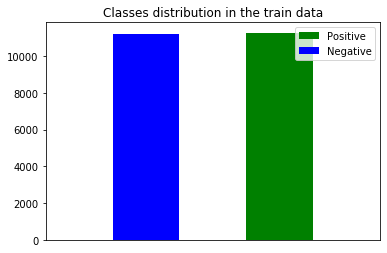

Positive: 11278 - Negative: 11222


In [8]:
# how many possitive and negative labels?
plt.hist(data[data.sentiment == 1].sentiment,
         bins=2, color='green', label='Positive')
plt.hist(data[data.sentiment == 0].sentiment,
         bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data')
plt.xticks([data[data.sentiment == 1].sentiment.count(), data[data.sentiment == 0].sentiment.count()])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()
print('Positive: {} - Negative: {}'.format(data[data.sentiment == 1].sentiment.count(), data[data.sentiment == 0].sentiment.count()))

In [9]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
data['word count'] = data['review'].apply(word_count)

In [10]:
data.head(5)

,review,sentiment,word count
0,With all this stuff going down at the moment w...,1,433
1,"\The Classic War of the Worlds\"" by Timothy Hi...",1,158
2,The film starts with a manager (Nicholas Bell)...,0,378
3,It must be assumed that those who praised this...,0,379
4,Superbly trashy and wondrously unpretentious 8...,1,367


#### Word count distribution

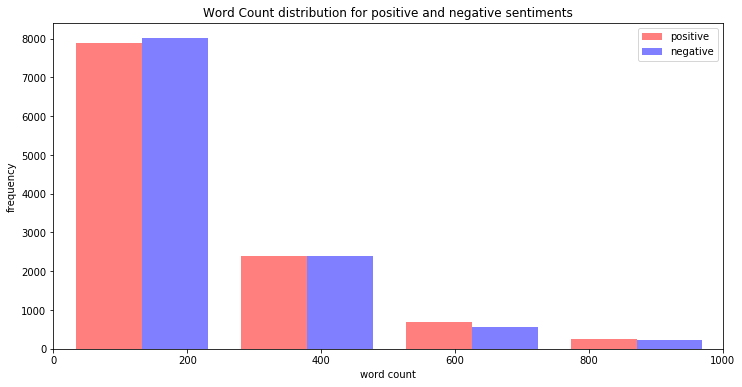

In [11]:
# plot word count distribution for both positive and negative sentiments
x = data['word count'][data.sentiment == 1]
y = data['word count'][data.sentiment == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,1000)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')
plt.title("Word Count distribution for positive and negative sentiments")
plt.show()

#### Most common words 

In [12]:
# get most common words in training dataset
all_words = []
for line in list(data['review']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())

Counter(all_words).most_common(20)

[('the', 290182),
 ('a', 144051),
 ('and', 142724),
 ('of', 130112),
 ('to', 120539),
 ('is', 93742),
 ('in', 81699),
 ('i', 63363),
 ('this', 62661),
 ('that', 59553),
 ('it', 58825),
 ('/><br', 45851),
 ('was', 42295),
 ('as', 40642),
 ('for', 38520),
 ('with', 38406),
 ('but', 35782),
 ('on', 28508),
 ('movie', 27684),
 ('his', 26285)]

## Preprocessing

In [13]:
# We only pick the most common words from the list above as stop words 
# because the list of full english stop words from nltk seem to be too expansive
# and tend to decrease our model performance.
stop_words = ['the', 'a', 'and', 'of', 'to', 'is', 'in', 'i']

In [14]:
stop_words

['the', 'a', 'and', 'of', 'to', 'is', 'in', 'i']

In [15]:
# Remove special characters, html tags and "trash"
def clean_text(text):
  # remove HTML markup
  text = re.sub('<[^>]*>', '', text)
  
  # Save emoticons for later appending
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  # Now remove emoticons
  text = re.sub('(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', text)
  
  # Remove some special characters
  text = re.sub('Ã\x82Â¨', '', text)
  
  # Save number in 1,000 or 1.000 formats for later appending
  numbers = re.findall(r'(?<!,)\b(\d{1,3}(?:[.,]\d{3})*)\b(?!,)', text)
  # Now remove numbers
  text = re.sub(r'(?<!,)\b(\d{1,3}(?:[.,]\d{3})*)\b(?!,)', '', text)
  
  # Remove any non-word character and append the emoticons,
  # removing the nose character for standardization. Convert to lower case
  text = (re.sub('[\W]+', ' ', text.lower()))
  
  # Remove words with 2 or fewer letters
#   text = re.sub(r'\b\w{1,2}\b', '', text)
  
  # Remove whitespace (including new line characters)
  text = re.sub(r'\s\s+', ' ', text)
  
  # Remove single space remaining.
  text = text.strip(' ') 
  
  # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
  text = ''.join(c for c in text if c <= '\uFFFF') 
  
  # rejoin emoticons & numbers
  text = text + ' ' + ' '.join(emoticons).replace('-', '') + ' ' + ' '.join(numbers).replace('.', '').replace(',', '')
  
  return text

  
# Tokenizer and Stemming
# tokenizer: to break down our twits in individual words
# stemming: reducing a word to its root
porter = PorterStemmer()

def preprocessor_stem(text):
  
  text = clean_text(text)
  # stemming
  text = [porter.stem(word) for word in text.split()]
  # Remove stop words
  text = [word for word in text if not word in stop_words]
  text = " ".join(text)
  return text
  
def tokenizer(text):
  return [word for word in text.split()]

In [16]:
# Test clean text
string = 'Yeah :-D I love loving loved loovveee this one so much him =) Ã\x82Â¨10.000 BC(2006)Ã\x82Â¨ !@#% Blah #()@...,<,<> Ã\x82Â¨Jurassik ParkÃ\x82Â¨'
string = clean_text(string)
print(string)

yeah i love loving loved loovveee this one so much him bc 2006 blah jurassik park :D =) 10000


In [17]:
# Test clean text with stemming
string_token = preprocessor_stem(string)
print(tokenizer(string_token))

['yeah', 'love', 'love', 'love', 'loovvee', 'thi', 'one', 'so', 'much', 'him', 'bc', '2006', 'blah', 'jurassik', 'park', '10000', ':D', '=)']


In [18]:
# data.drop(columns='stem processed review', inplace=True)
data.insert(loc = 1, column="stem processed review", value="")

In [19]:
data['stem processed review'] = data['review'].apply(preprocessor_stem)

In [20]:
data['stem processed review word count'] = data['stem processed review'].apply(word_count)

In [21]:
data.head()

,review,stem processed review,sentiment,word count,stem processed review word count
0,With all this stuff going down at the moment w...,with all thi stuff go down at moment with mj v...,1,433,349
1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world by timothi hine veri enterta...,1,158,131
2,The film starts with a manager (Nicholas Bell)...,film start with manag nichola bell give welcom...,0,378,306
3,It must be assumed that those who praised this...,it must be assum that those who prais thi film...,0,379,293
4,Superbly trashy and wondrously unpretentious 8...,superbl trashi wondrous unpretenti s exploit h...,1,367,318


### Create Train - Test Subsets

In [22]:
X = data['review']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [23]:
t0 = time.time()
tfidf = TfidfVectorizer(tokenizer=tokenizer, preprocessor=preprocessor_stem)
X_tfidf = tfidf.fit_transform(X)
t1 = time.time()

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.25, random_state=101)
t2 = time.time()

time_vectorizing = t1-t0
time_splitting = t2-t1

print("Vectorizing time: %fs; Train-Test Splitting time: %fs" % (time_vectorizing, time_splitting))

Vectorizing time: 104.501336s; Train-Test Splitting time: 0.015165s


In [24]:
X_train_tfidf.shape

(16875, 50765)

## Model training and evaluation
We will explore different classifiers to evaluate the most efficient one in term of accuracy and computational difficulty.

### Logistic Regression Classifier

In [25]:
lr = LogisticRegression()
t0 = time.time()

lr.fit(X_train_tfidf, y_train_tfidf)
t1 = time.time()

lr_preds = lr.predict(X_test_tfidf)
t2 = time.time()

time_linear_train = t1-t0
time_linear_predict = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

lr_cm = confusion_matrix(y_test_tfidf, lr_preds)
lr_report = classification_report(y_test_tfidf, lr_preds)

Training time: 0.472388s; Prediction time: 0.002701s


In [26]:
print(lr_cm)
print(lr_report)

[[2487  343]
 [ 262 2533]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2830
           1       0.88      0.91      0.89      2795

    accuracy                           0.89      5625
   macro avg       0.89      0.89      0.89      5625
weighted avg       0.89      0.89      0.89      5625



### Decision Tree Classifier

In [27]:
dtc = DecisionTreeClassifier()
t0 = time.time()
dtc.fit(X_train_tfidf, y_train_tfidf)
t1 = time.time()

dtc_preds = dtc.predict(X_test_tfidf)
t2 = time.time()

time_dtc_train = t1-t0
time_dtc_predict = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_dtc_train, time_dtc_predict))

dtc_cm = confusion_matrix(y_test_tfidf, dtc_preds)
dtc_report = classification_report(y_test_tfidf, dtc_preds)

Training time: 21.884957s; Prediction time: 0.047053s


In [28]:
print(dtc_cm)
print(dtc_report)

[[1970  860]
 [ 775 2020]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71      2830
           1       0.70      0.72      0.71      2795

    accuracy                           0.71      5625
   macro avg       0.71      0.71      0.71      5625
weighted avg       0.71      0.71      0.71      5625



### Random Forest Classifier

In [29]:
rfc = RandomForestClassifier()

t0 = time.time()
rfc.fit(X_train_tfidf, y_train_tfidf)
t1 = time.time()

rfc_preds = rfc.predict(X_test_tfidf)
t2 = time.time()

time_rfc_train = t1-t0
time_rfc_predict = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_rfc_train, time_rfc_predict))

rfc_cm = confusion_matrix(y_test_tfidf, rfc_preds)
rfc_report = classification_report(y_test_tfidf, rfc_preds)

Training time: 4.315481s; Prediction time: 0.064325s


In [30]:
print(rfc_cm)
print(rfc_report)

[[2330  500]
 [ 959 1836]]
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      2830
           1       0.79      0.66      0.72      2795

    accuracy                           0.74      5625
   macro avg       0.75      0.74      0.74      5625
weighted avg       0.75      0.74      0.74      5625



### K-Neighbors Nearest Classifier

In [31]:
knn = KNeighborsClassifier()

t0 = time.time()
knn.fit(X_train_tfidf, y_train_tfidf)
t1 = time.time()

knn_preds = knn.predict(X_test_tfidf)
t2 = time.time()

time_knn_train = t1-t0
time_knn_predict = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_knn_train, time_knn_predict))

knn_cm = confusion_matrix(y_test_tfidf, knn_preds)
knn_report = classification_report(y_test_tfidf, knn_preds)

Training time: 0.011539s; Prediction time: 11.236705s


In [32]:
print(knn_cm)
print(knn_report)

[[2112  718]
 [ 450 2345]]
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      2830
           1       0.77      0.84      0.80      2795

    accuracy                           0.79      5625
   macro avg       0.79      0.79      0.79      5625
weighted avg       0.80      0.79      0.79      5625



### Support Vector Machine Classifier

In [33]:
svm = SVC(kernel='linear')

t0 = time.time()
svm.fit(X_train_tfidf, y_train_tfidf)
t1 = time.time()

svm_preds = svm.predict(X_test_tfidf)
t2 = time.time()

time_svm_train = t1-t0
time_svm_predict = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_svm_train, time_svm_predict))

svm_cm = confusion_matrix(y_test_tfidf, svm_preds)
svm_report = classification_report(y_test_tfidf, svm_preds)

Training time: 184.447986s; Prediction time: 39.993499s


In [34]:
print(svm_cm)
print(svm_report)

[[2502  328]
 [ 282 2513]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2830
           1       0.88      0.90      0.89      2795

    accuracy                           0.89      5625
   macro avg       0.89      0.89      0.89      5625
weighted avg       0.89      0.89      0.89      5625



### Export Trained Models, default mode

In [35]:
# Using pickle to export our trained model
pickle.dump(lr, open(os.path.join('models', 'Model_LR_default_imdb.pkl'), 'wb'), protocol=4)
pickle.dump(dtc, open(os.path.join('models', 'Model_DTC_default_imdb.pkl'), 'wb'), protocol=4)
pickle.dump(rfc, open(os.path.join('models', 'Model_RFC_default_imdb.pkl'), 'wb'), protocol=4)
pickle.dump(knn, open(os.path.join('models', 'Model_KNN_default_imdb.pkl'), 'wb'), protocol=4)
pickle.dump(svm, open(os.path.join('models', 'Model_SVM_default_imdb.pkl'), 'wb'), protocol=4)

### Performance Comparison

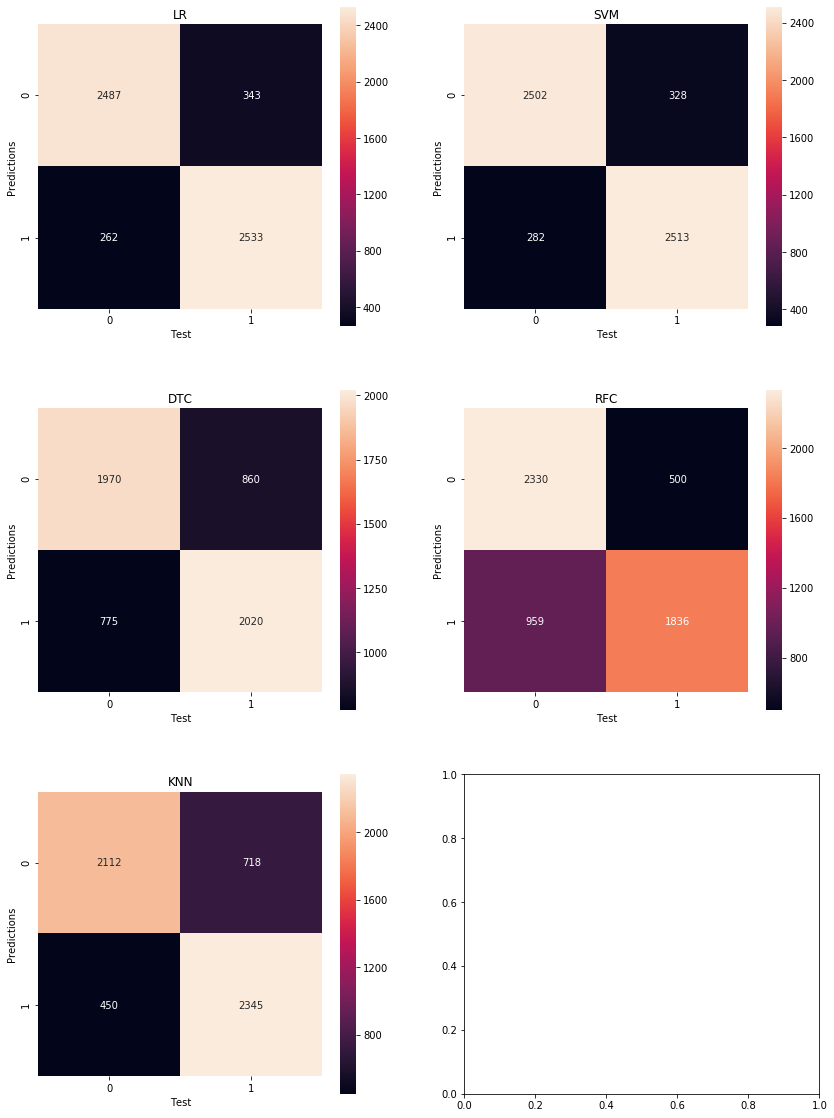

In [36]:
fig, ax = plt.subplots(3,2, figsize=[14,20])

sns.heatmap(lr_cm, ax=ax[0, 0], annot=True, fmt='d', square=True)
ax[0, 0].set_title('LR')
ax[0, 0].set_xlabel('Test')
ax[0, 0].set_ylabel('Predictions')

sns.heatmap(svm_cm, ax=ax[0, 1], annot=True, fmt='d', square=True)
ax[0, 1].set_title('SVM')
ax[0, 1].set_xlabel('Test')
ax[0, 1].set_ylabel('Predictions')

sns.heatmap(dtc_cm, ax=ax[1, 0], annot=True, fmt='d', square=True)
ax[1, 0].set_title('DTC')
ax[1, 0].set_xlabel('Test')
ax[1, 0].set_ylabel('Predictions')

sns.heatmap(rfc_cm, ax=ax[1, 1], annot=True, fmt='d', square=True)
ax[1, 1].set_title('RFC')
ax[1, 1].set_xlabel('Test')
ax[1, 1].set_ylabel('Predictions')

sns.heatmap(knn_cm, ax=ax[2, 0], annot=True, fmt='d', square=True)
ax[2, 0].set_title('KNN')
ax[2, 0].set_xlabel('Test')
ax[2, 0].set_ylabel('Predictions')

plt.show()

### Conclusion
Base on the confusion matrix diagrams, we can see that Logistic Regression and SVM are the two most effecient models. But Logistic Regression outperforms SVM in term of computation time. Now we can choose the Logistic Regression model and fine tune it.

# Optimization

## Feature Optimization: Lemmatization vs Stemming

We make an experiment between lemmatization and stemming to see which one contribute to a better accuracy for our model.

**Stemming** usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes.

**Lemmatization** usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma

For instance:

* The word "better" has "good" as its lemma. This link is missed by stemming, as it requires a dictionary look-up.
* The word "walk" is the base form for word "walking", and hence this is matched in both stemming and lemmatisation.
* The word "meeting" can be either the base form of a noun or a form of a verb ("to meet") depending on the context, e.g., "in our last meeting" or "We are meeting again tomorrow". Unlike stemming, lemmatisation can in principle select the appropriate lemma depending on the context.


### Lemmatization: Preprocessing

In [37]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jodythai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
def preprocessor_lemma(text):
  text = clean_text(text)
  
  # Lemmatizing
  text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
  text = [lemmatizer.lemmatize(token, "v") for token in text]
  
  # Remove stop words
  text = [word for word in text if not word in stop_words]
  
  text = " ".join(text)
  
  return text

In [39]:
# data.drop(columns='lemma processed review', inplace=True)
data.insert(loc = 2, column="lemma processed review", value="")

In [40]:
data['lemma processed review'] = data['review'].apply(preprocessor_lemma)

In [41]:
data['lemma processed review word count'] = data['lemma processed review'].apply(word_count)
data.head()

,review,stem processed review,lemma processed review,sentiment,word count,stem processed review word count,lemma processed review word count
0,With all this stuff going down at the moment w...,with all thi stuff go down at moment with mj v...,with all this stuff go down at moment with mj ...,1,433,349,363
1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world by timothi hine veri enterta...,classic war world by timothy hines be very ent...,1,158,131,132
2,The film starts with a manager (Nicholas Bell)...,film start with manag nichola bell give welcom...,film start with manager nicholas bell give wel...,0,378,306,308
3,It must be assumed that those who praised this...,it must be assum that those who prais thi film...,it must be assume that those who praise this f...,0,379,293,290
4,Superbly trashy and wondrously unpretentious 8...,superbl trashi wondrous unpretenti s exploit h...,superbly trashy wondrously unpretentious s exp...,1,367,318,317


**The lemmatizing review content looks a bit different than the stemming version**

## Parameter Tuning with GridSearchCV
We find the best **C** and **n-gram** values for our model.

In an n-gram vector, text is represented as a collection of unique n-grams: groups of n adjacent tokens (typically, words). Consider the text The mouse ran up the clock. Here, the word unigrams (n = 1) are ['the', 'mouse', 'ran', 'up', 'clock'], the word bigrams (n = 2) are ['the mouse', 'mouse ran', 'ran up', 'up the', 'the clock'], and so on.

In [ ]:
from sklearn.pipeline import Pipeline
        
pipeline = Pipeline([ 
                      ('tfidf', TfidfVectorizer(sublinear_tf=True, 
                                                tokenizer=tokenizer,
                                                preprocessor=preprocessor_lemma)),
                      ('classifier', LogisticRegression()),  
                    ])

parameters = {
              'tfidf__ngram_range': [(1,1), (1,2)],
              'tfidf__max_features' : (20000, 25000, 30000, 50000, 80000),
              'classifier__C': (0.1, 1, 1.1, 2, 2.1, 3, 3.1, 4, 5),
              'classifier__solver': ('sag', 'liblinear')
             }

grid = GridSearchCV(pipeline, cv=5, param_grid=parameters)
grid.fit(X_train, y_train)

In [ ]:
# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

### Train model using lemmatization

In [ ]:
t0 = time.time()
tfidf_lemma = TfidfVectorizer(sublinear_tf=True,
                              preprocessor=preprocessor_lemma,
                              tokenizer=tokenizer,
                              ngram_range=(1, 2),
                              max_features = 25000
                             )

lr_lemma = Pipeline([('vect', tfidf_lemma),
                ('clf', LogisticRegression(C=5, solver='sag'))])

lr_lemma.fit(X_train, y_train)
t1 = time.time()

lr_lemma_preds = lr_lemma.predict(X_test)
t2 = time.time()

time_linear_train_lr_lemma = t1-t0
time_linear_predict_lr_lemma = t2-t1

print("Training time: %fs; Prediction time: %fs" % (time_linear_train_lr_lemma, time_linear_predict_lr_lemma))

In [ ]:
lr_lemma_cm = confusion_matrix(y_test, lr_lemma_preds)
lr_lemma_report = classification_report(y_test, lr_lemma_preds)

In [ ]:
print(lr_lemma_cm)
print(lr_lemma_report)

###  Train model using stemming

In [ ]:
t0 = time.time()
tfidf_stem = TfidfVectorizer(sublinear_tf=True,
                              preprocessor=preprocessor_stem,
                              tokenizer=tokenizer,
                              ngram_range=(1, 2),
                              max_features = 25000
                             )

lr_stem = Pipeline([('vect', tfidf_stem),
                ('clf', LogisticRegression(C=5, solver='sag'))])

lr_stem.fit(X_train, y_train)
t1 = time.time()

lr_stem_preds = lr_stem.predict(X_test)
t2 = time.time()

time_linear_train_lr_stem = t1-t0
time_linear_predict_lr_stem = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train_lr_stem, time_linear_predict_lr_stem))

lr_stem_cm = confusion_matrix(y_test, lr_stem_preds)
lr_stem_report = classification_report(y_test, lr_stem_preds)

In [ ]:
print(lr_stem_cm)
print(lr_stem_report)

### Validating using K-Fold CV
Finally, to make sure that our train models are not biased by the dataset, we use K-Fold CV to validate them.

In [ ]:
lr_lemma_scores = cross_val_score(lr_lemma, X_train_tfidf_lemma, y_train_tfidf_lemma, cv=10)

In [ ]:
lr_stem_scores = cross_val_score(lr_stem, X_train_tfidf_stem, y_train_tfidf_stem, cv=10)

In [ ]:
lr_lemma_scores.mean()

In [ ]:
lr_stem_scores.mean()

### Performance Comparison

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=[14,7])

sns.heatmap(lr_lemma_cm, ax=ax[0], annot=True, fmt='d', square=True)
ax[0].set_title('LR LEMMA')
ax[0].set_xlabel('Test')
ax[0].set_ylabel('Predictions')

sns.heatmap(lr_stem_cm, ax=ax[1], annot=True, fmt='d', square=True)
ax[1].set_title('LR STEM')
ax[1].set_xlabel('Test')
ax[1].set_ylabel('Predictions')

plt.show()

### Conclusion

Lemmatization improves our model over Stemming, but not significantly.

### Save trained model: tuned mode

In [ ]:
pickle.dump(lr_lemma, open(os.path.join('models', 'Model_LR_imdb_tuned_f1-91_recall-92_lemma.pkl'), 'wb'), protocol=4)
pickle.dump(lr_stem, open(os.path.join('models', 'Model_LR_imdb_tuned_f1-91_recall-92_stem.pkl'), 'wb'), protocol=4)

## Investigate wrong predictions

In [ ]:
wrong_predictions_filter = lr_lemma_preds != y_test_tfidf_lemma

In [ ]:
index = 0
print('Predictions:', lr_lemma_preds[wrong_predictions_filter][index])
print('Actual:', y_test_tfidf_lemma[wrong_predictions_filter].iloc[index])
print('Actual Index:', y_test_tfidf_lemma[wrong_predictions_filter].index[index])
print('Review:', data.iloc[y_test_tfidf_lemma[wrong_predictions_filter].index[index]]['lemma processed review'])

## Predict Test Data

### Load Trained Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
model_lr_lemma = pickle.load(open('./models/Model_LR_imdb_tuned_f1-91_recall-92_lemma.pkl', 'rb'))
# model_lr_stem = pickle.load(open('./models/Model_LR_imdb_tuned_f1-91_recall-92_stem.pkl', 'rb'))

In [ ]:
data_test = pd.read_csv('./data/movie_review_noLabel.csv', sep='\t', encoding='latin-1')

In [ ]:
data_test.head()

### Predict

In [ ]:
final_preds_lemma = model_lr_lemma.predict(data_test['review'])
# final_preds_stem = model_lr_stem.predict(data_test['review'])

In [ ]:
data_test['sentiment'] = final_preds_stem

In [ ]:
data_test.head()

In [ ]:
data_test.to_csv('./data/results.csv',index=True)

## Conclusion

We achieve 92% accuracy using Logistic Regression with three main tweaks in feature optimization: improve the clean text process, ngram_range and lemmatization.

During the reseach for this project, we discover that there are some potential improvements we can experiment to incease the accuracy of the model:
1. Implement Gradient Boosting framework (XG Boost, LightGBM, CatBoost)
2. Use Word2Vec to improve dataset features
3. Feature Selection: Calculate the Positive & Negative for each sentence in the review, then store the mean value as a feature.